# CTR Calculator Demo
This is a demonstration of the software tool that assists with camera resolution evaluation during the optical streak camera calibration process. The image analyzed must be a flatfield with a Ronchi Ruling mask.

Produces CTR measurements throughout an image and retrieves specific measurements at points of interest.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import stats
from scipy.signal import find_peaks, argrelmin

The user-defined paramters allow the user to:
- Define minimum number of peaks required to analyze the image
- Define swath size
- Ability to offset edges of data

In [2]:
# User-defined parameters:

# name of saved image
filename = 'TIF/10s_FF_5lppmm_RR.TIF'
# define minimum required peaks
minpeaks = 50
# define swath size
swath_size = 40
# offset edges of data (in pixels)
left_offset = 0
right_offset = 0

In [3]:
# determine CTR throughout a lineout
def get_ctr(line):
    # find peaks in the lineout
    peaks, _ = find_peaks(line, width=3)
    # find local minima in the lineout
    mins = argrelmin(line)[0]
    
    # initialize arrays
    ctr = np.array([])
    non_zero = []
    # determine CTR for each 40-pixel window across lineout
    for i in range(20, len(line)-20):
        window_peaks = line[peaks[np.logical_and(peaks > i-20, peaks < i+20)]]
        # if no peaks in window, CTR is 0
        if not len(window_peaks):
            ctr = np.append(ctr, 0.0)
            continue
        # find highest peak in 40-pixel swath
        max_peak = max(window_peaks)
        # if highest peak is not significant, CTR is 0
        if max_peak < background + stdev:
            ctr = np.append(ctr, 0.0)
        else:
            # find local minima in the 40-pixel window
            min_val = min(line[mins[np.logical_and(mins > i-20, mins < i+20)]])
            # perform CTR calculation
            result = (max_peak - min_val)/(max_peak + min_val - 2*background)
            # CTR cannot be > 100%, if it is, record 0 (no data)
            if result > 1.0:
                ctr = np.append(ctr, 0.0)
            else:
                ctr = np.append(ctr, result)
                non_zero.append(i)
        if not len(non_zero):
            non_zero.append(None)
    # return image CTR with left and right limits of data
    return (np.array([ctr]), non_zero[0], non_zero[-1])

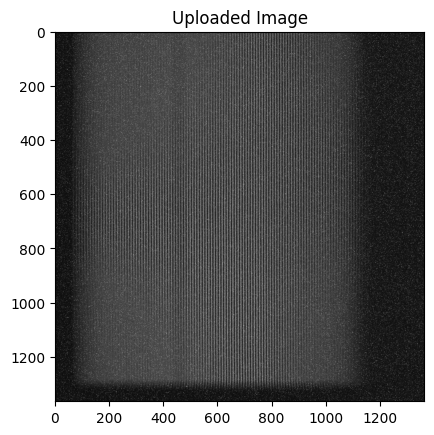

In [4]:
# import image data
fimg = Image.open(filename)
img = np.array(fimg)
plt.imshow(img, cmap="grey")
plt.title("Uploaded Image")
plt.show()

In [5]:
# determine correct orientation for image

# take sample from middle
midpoint = len(img) // 2
sample = np.mean(img[midpoint - 10:midpoint + 10], axis=0)
# find peaks in the sample
peaks, _ = find_peaks(sample, width=3)

# if the image doesn't fit the evaluation criteria, rotate and try again
if len(peaks) < minpeaks:
    img = np.rot90(img, axes=(1,0))
    midpoint = len(img) // 2
    sample = np.mean(img[midpoint - 10:midpoint + 10], axis=0)
    peaks, _ = find_peaks(sample, width=3)
    if len(peaks) < minpeaks:
        # if criteria still not met, raise an exception
        raise ValueError("Image cannot be evaluated. Please choose another image.")
    plt.imshow(img, cmap="grey")
    plt.title("Rotated Image")
    plt.show()

In [6]:
# find background counts (approximate mode of image data)
bins = np.linspace(0,65000, 101)
bin_indices = np.digitize(img.reshape(len(img)*len(img[0])), bins)
background = bins[stats.mode(bin_indices)[0]]
# find standard deviation of image data
stdev = np.std(img.reshape(len(img)*len(img[0])))

print("Approximate Background Counts:", background)
print("Standard Deviation of Image:", stdev)

Approximate Background Counts: 3900.0
Standard Deviation of Image: 9317.079351868675


In [7]:
# initialize image CTR with first line
swath = np.mean(img[:swath_size], axis=0)
image_ctr, l, r = get_ctr(swath)
# keep track of left and right limits of data for each swath
left_limit = []
right_limit = []

# calculate CTR for each swath
for i in range(len(img) - swath_size):
    # get swath lineout
    swath = np.mean(img[i:i+swath_size], axis=0)
    # get CTR across swath
    line_ctr, l, r = get_ctr(swath)
    # add to CTR of whole image
    image_ctr = np.append(image_ctr, line_ctr, axis=0)
    # add left and right limits
    if l:
        left_limit.append(l)
    if r:
        right_limit.append(r)

# calculate average of left and right limits for the image
left_limit = np.mean(np.array(left_limit)) + left_offset
right_limit = np.mean(np.array(right_limit)) + right_offset

# show parameters
print("Left limit:", left_limit)
print("Right limit:", right_limit)

Left limit: 104.71186440677967
Right limit: 1110.4336147352265


In [8]:
# retrieve points of interest
y = np.array([len(img) // 4]*3)
for _ in range(3):
    y = np.append(y, [len(img) // 2])
for _ in range(3):
    y = np.append(y, [len(img)*3 // 4])
x = np.array([int((3*left_limit + right_limit) // 4),
     int((left_limit + right_limit) // 2),
     int((left_limit + 3*right_limit) // 4)] * 3)

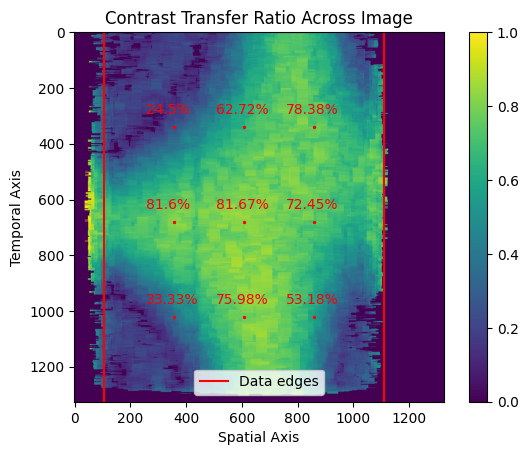

In [9]:
# map CTR results for image
plt.imshow(image_ctr)
plt.axvline(x=left_limit, color = 'r', label="Data edges")
plt.axvline(x=right_limit, color = 'r')
# plot points of interest
plt.scatter(x, y, color='r', s=2)
# display CTR values for points of interest
for i in range(9):
    percentage = str(round(image_ctr[y[i]][x[i]]*100, 2)) + "%"
    plt.text(x[i] - 100, y[i] - 50, percentage, color='r')
plt.colorbar()
plt.title("Contrast Transfer Ratio Across Image")
plt.xlabel("Spatial Axis")
plt.ylabel("Temporal Axis")
plt.legend()
plt.show()